In [1]:
import collections
import gc
import re

import cufflinks as cf
import jieba
import matplotlib
import matplotlib.pyplot as plt
import missingno as msno
import pandas as pd
import seaborn as sns
from wordcloud import WordCloud

%matplotlib inline
cf.go_offline()
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('max_colwidth',200)
plt.style.use('seaborn')

第一次玩DF,发一个简单的疫情文本EDA试试。如果有帮助请点个赞。

## 读取数据

由于其他编码会出现少部分汉字乱码，比如“XX超话”、表情符号等。所以我手动用记事本转换成了 UTF-8 编码。

其中，超话以及其他特殊字符以“”表示，大部分表情符号被“??”代替。

In [2]:
train_labeled = pd.read_csv('./input/train_dataset/nCoV_100k_train_labled_utf8.csv', encoding='utf-8')
train_labeled.rename(columns = {"微博id": "Weibo_ID",
                                "微博发布时间": "Publish_Time", 
                                "发布人账号": "Account_ID",
                                "微博中文内容": "Chinese_Content",
                                "微博图片": "Pictures",
                                "微博视频": "Videos",
                                "情感倾向": "Labels"},  inplace=True)

train_labeled_copy = train_labeled.copy()

In [3]:
test = pd.read_csv('./input/test_dataset/nCov_10k_test_utf8.csv', encoding='utf-8')
test.rename(columns = {"微博id": "Weibo_ID",
                                "微博发布时间": "Publish_Time", 
                                "发布人账号": "Account_ID",
                                "微博中文内容": "Chinese_Content",
                                "微博图片": "Pictures",
                                "微博视频": "Videos"},  inplace=True)

test_copy = test.copy()

In [6]:
train_labeled.head(3)

,Weibo_ID,Publish_Time,Account_ID,Chinese_Content,Pictures,Videos,Labels
0,4456072029125500,01月01日 23:50,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早晨给孩子穿上红色的羽绒服羽绒裤，祈祷新的一年，孩子们身体康健。仍然会有一丝焦虑，焦虑我的孩子为什么会过早的懂事，从两岁多开始关注我的情绪，会深沉地说：妈妈，你终于笑了！这句话像刀子一样扎入我?展开全文c,['https://ww2.sinaimg.cn/orj360/005VnA1zly1gahhwworn5j30m80fyq4n.jpg'],[],0
1,4456074167480980,01月01日 23:58,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,[],[],-1
2,4456054253264520,01月01日 22:39,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年快乐，发烧好了就去浪吧，快快乐乐的度过这个美好假期，说不定以后就没有了嗷@邱晨虫仔2泉州·泉州理工学院?,"['https://ww2.sinaimg.cn/thumb150/006ymYXKgy1gahft9xvnbj31o00u0jxt.jpg', 'https://ww1.sinaimg.cn/thumb150/006ymYXKgy1gahftblqogj31o00u0agj.jpg', 'https://ww4.sinaimg.cn/thumb150/006ymYXKgy1gahftdd...",[],1


In [7]:
test.head(3)

,Weibo_ID,Publish_Time,Account_ID,Chinese_Content,Pictures,Videos
0,4456068992182160,01月01日 23:38,-精緻的豬豬女戰士-,#你好2020#新年第一天元气满满的早起出门买早饭结果高估了自己抗冻能力回家成功冻发烧（大概是想告诉我2020要量力而行）然鹅这并不影响后续计划一出门立马生龙活虎新年和新??更配哦??看了误杀吃了大餐就让新的一年一直这样美滋滋下去吧???,"['https://ww2.sinaimg.cn/thumb150/745aa591ly1gahhjvh2k7j211u0u0th2.jpg', 'https://ww3.sinaimg.cn/thumb150/745aa591ly1gahhjb3ueqj20u0140dnn.jpg', 'https://ww2.sinaimg.cn/orj360/745aa591ly1gahhjar7n...",[]
1,4456424178427250,01月02日 23:09,liujunyi88,大宝又感冒鼻塞咳嗽了，还有发烧。队友加班几天不回。感觉自己的情绪在家已然是随时引爆的状态。情绪一上来，容易对孩子说出自己都想不到的话来……2020年，真的要学会控制情绪，管理好家人健康。这是今年最大的目标。?,[],[]
2,4456797466940200,01月03日 23:53,ablsa,还要去输两天液，这天也太容易感冒发烧了，一定要多喝热水啊?,['https://ww3.sinaimg.cn/orj360/006fTidCly1gajt7wulilj31o01o07wh.jpg'],[]


## 缺失值检查

检查一下训练集和测试集的缺失值，可以看出有些数据是缺失的。

In [8]:
train_labeled.isnull().any()

Weibo_ID           False
Publish_Time       False
Account_ID         False
Chinese_Content     True
Pictures           False
Videos             False
Labels              True
dtype: bool

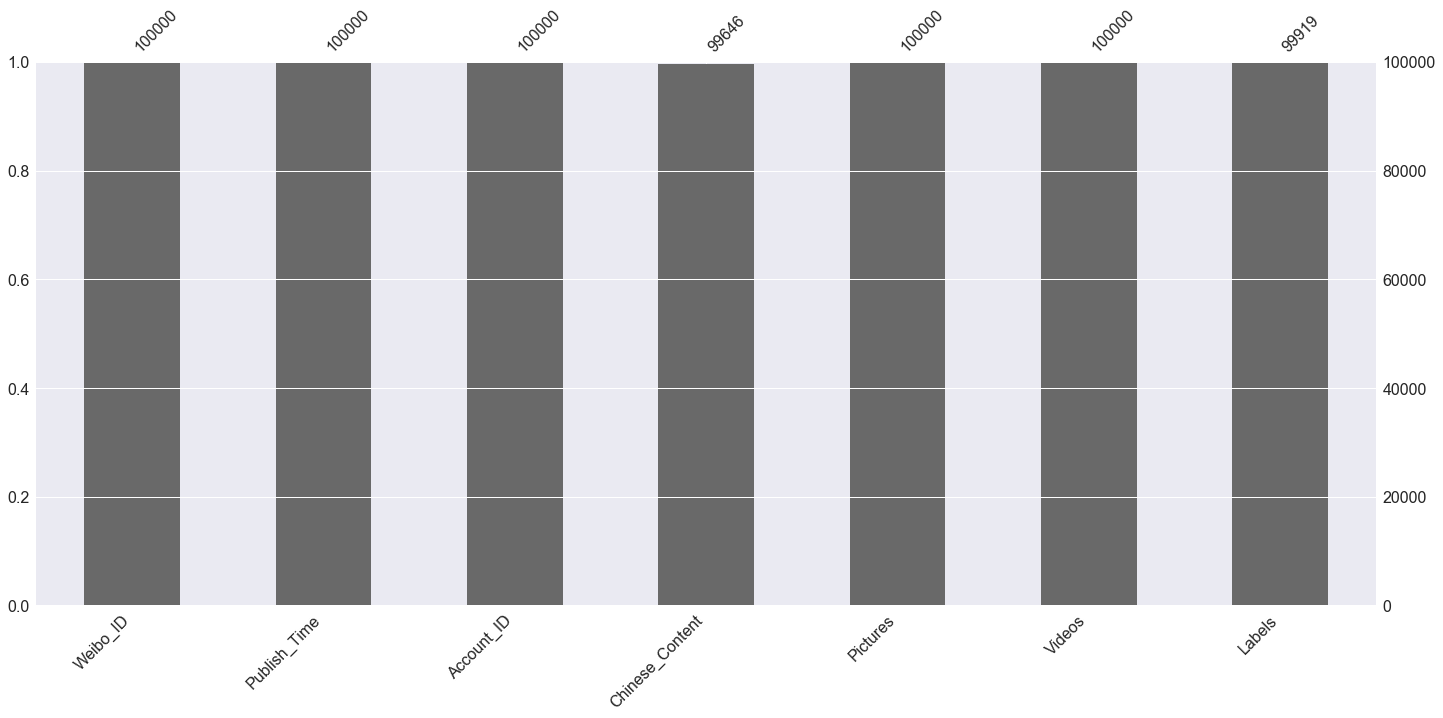

In [9]:
msno.bar(train_labeled)

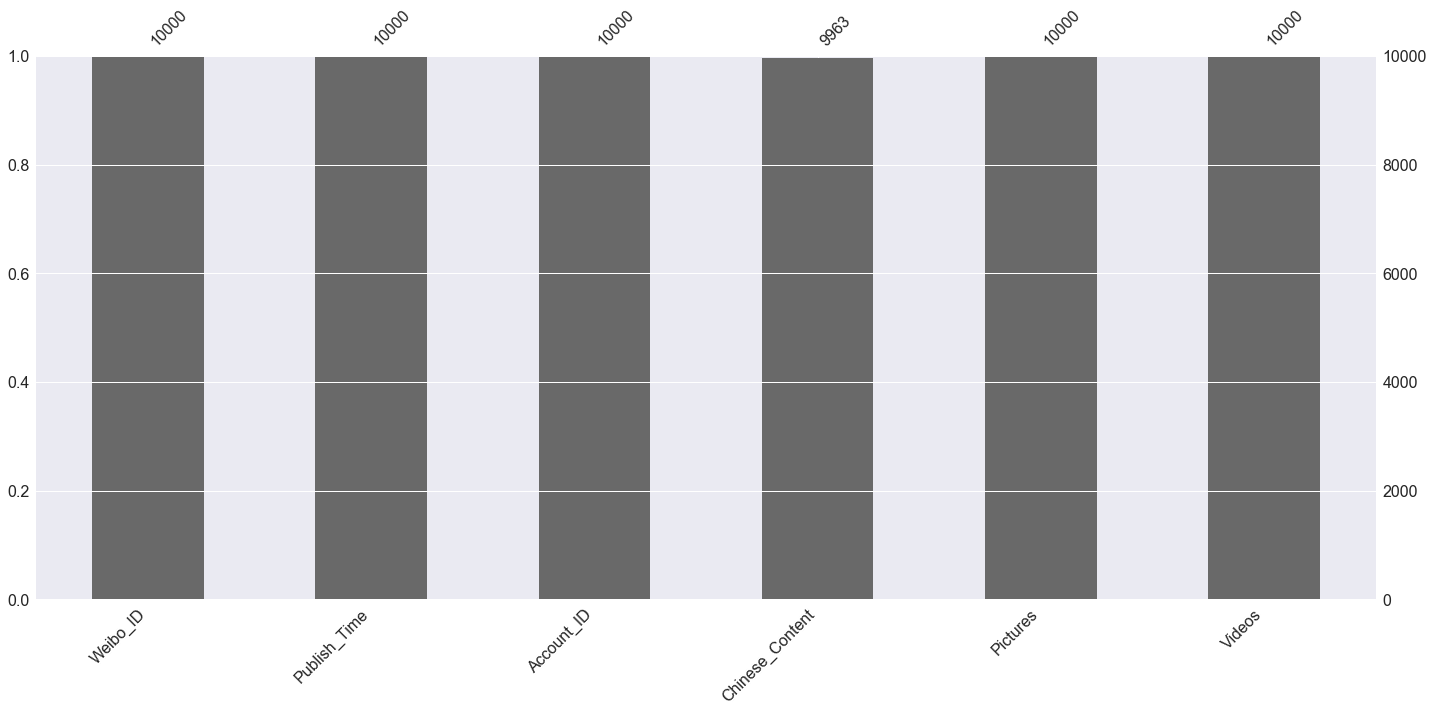

In [10]:
msno.bar(test)

有少量微博正文数据丢失，部分labels为空。

## 标签检查

标签统计如下：

In [11]:
train_labeled_copy.fillna({"Labels": "empty_label"}, inplace=True)

temp = train_labeled_copy["Labels"].value_counts()
temp_df = pd.DataFrame({'labels': temp.index,
                        'values': temp.values})

temp_df.iplot(kind='pie',labels='labels',values='values', title='Labels')

有6种噪音标签，每种各一个，此外还有一点点空标签，统计如下:

In [12]:
noise = train_labeled_copy[(train_labeled_copy["Labels"] != '0') & 
                           (train_labeled_copy["Labels"] != '1') & 
                           (train_labeled_copy["Labels"] != '-1')]

noise = noise["Labels"].value_counts()
noise_df = pd.DataFrame({'labels': noise.index,
                         'values': noise.values})

noise_df.iplot(kind='pie',labels='labels',values='values', title='奇怪标签统计')

对于非正常标签的处理，可以直接舍弃，也可以手工打上真正标签（如果不嫌累）。

这里我们直接舍弃就行。

## 发微博数量与时间关系

疫情和时间的分析用了包佬的代码。（你的代码很不错，不过下一秒就是我的了.jpg）

In [13]:
train_labeled_copy['time'] = pd.to_datetime('2020年' + train_labeled['Publish_Time'], format='%Y年%m月%d日 %H:%M', errors='ignore')
test_copy['time'] = pd.to_datetime('2020年' + train_labeled['Publish_Time'], format='%Y年%m月%d日 %H:%M', errors='ignore')

In [14]:
train_labeled_copy['month'] =  train_labeled_copy['time'].dt.month
train_labeled_copy['day'] =  train_labeled_copy['time'].dt.day
train_labeled_copy['dayfromzero']  = (train_labeled_copy['month'] - 1) * 31 +  train_labeled_copy['day']

test_copy['month'] =  test_copy['time'].dt.month
test_copy['day'] =  test_copy['time'].dt.day
test_copy['dayfromzero']  = (test_copy['month'] - 1) * 31 +  test_copy['day']

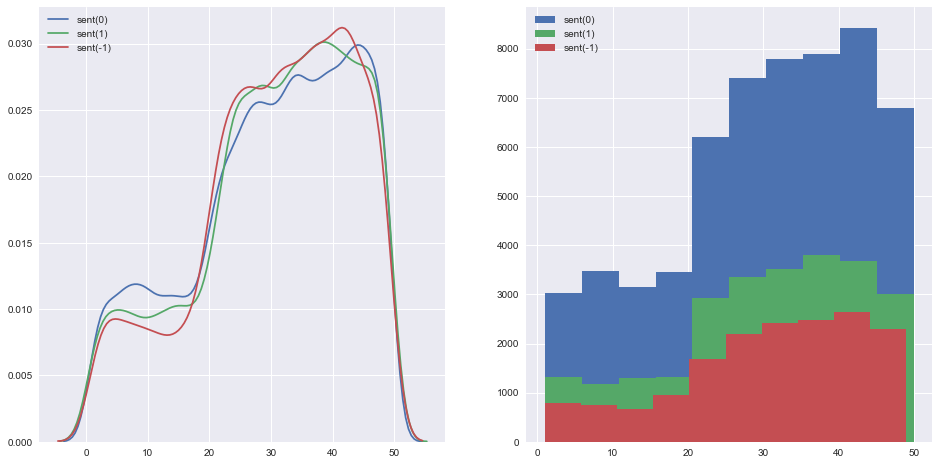

In [15]:
fig, ax = plt.subplots(1, 2, figsize=(16, 8))

sns.kdeplot(train_labeled_copy.loc[train_labeled_copy['Labels'] == '0', 'dayfromzero'], ax=ax[0], label='sent(0)')
sns.kdeplot(train_labeled_copy.loc[train_labeled_copy['Labels'] == '1', 'dayfromzero'], ax=ax[0], label='sent(1)')
sns.kdeplot(train_labeled_copy.loc[train_labeled_copy['Labels'] == '-1', 'dayfromzero'], ax=ax[0], label='sent(-1)')

train_labeled_copy.loc[train_labeled_copy['Labels'] == '0', 'dayfromzero'].hist(ax=ax[1])
train_labeled_copy.loc[train_labeled_copy['Labels'] == '1', 'dayfromzero'].hist(ax=ax[1])
train_labeled_copy.loc[train_labeled_copy['Labels'] == '-1', 'dayfromzero'].hist(ax=ax[1])
ax[1].legend(['sent(0)', 'sent(1)','sent(-1)'])

plt.show()

可以看出如下情况，顺便也帮大家找了找相关新闻节点（深藏功与名）：

- **1月18日**后，话题量有明显增长。
    - 1月19日：武汉CDC李刚：新冠人传人风险较低，传染力不强。
    - 1月20日：钟南山:新型肺炎存在人传人现象。
    - 1月20日：口罩出现抢购现象。
    - 1月23日：武汉封城。
    - 1月25日：火神山医院设计方案完成；雷神山医院建造决定。

- **二月九日**前后，话题量达到顶峰。
    - 2月7日：“吹哨人”李文亮医生不幸去世。
    - 2月10日：湖北省相关领导任免。

18日前官方口径（包括网友）们的态度还比较乐观，大部分认为“新冠可防可控”、“传染力有限”，然后钟南山院士对新冠“肯定存在人传人”的表态可能是导致话题量飙升的重要原因。

7日晚上李文亮医生不幸去世，微博和朋友圈都在刷屏，从曲线上看，相关话题量几乎到达顶峰。

（**悼念李文亮医生**）

## 正文长度统计

现在开始统计相关微博的长度，训练集和测试集都有。

In [16]:
train_labeled_copy['Chinese_Content_Length'] = train_labeled['Chinese_Content'].astype(str).apply(len)
test_copy['Chinese_Content_Length'] = train_labeled['Chinese_Content'].astype(str).apply(len)

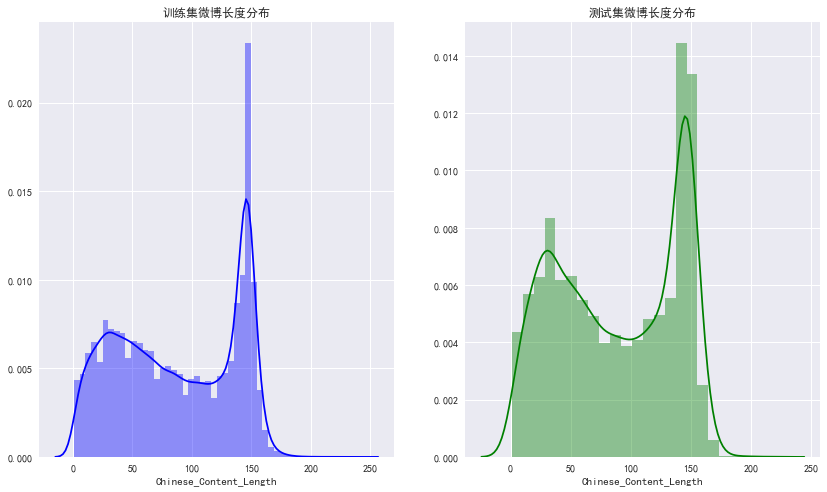

In [17]:
fig, (ax1, ax2) = plt.subplots(1,2,figsize=(14,8))
sns.distplot(train_labeled_copy['Chinese_Content_Length'], ax=ax1, color='blue')
sns.distplot(test_copy['Chinese_Content_Length'], ax=ax2, color='green')

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

ax1.set_title('训练集微博长度分布')
ax2.set_title('测试集微博长度分布')

plt.show()

看出点什么东西没？

### 正文词云

采用 `jieba` 和 `wordcloud` 对正文做一个词云。

In [18]:
stop = open('stopwords.txt', 'r+', encoding='utf-8')
stopword = stop.read().split("\n")
stopeword = set(stopword)
stop.close()

In [19]:
def stripword(seg):
    """停用词处理"""
    wordlist = []
    
    for key in seg.split(' '):
        #去除停用词和单字
        if not (key.strip() in stopword) and (len(key.strip()) > 1):
            wordlist.append(key)
    return ' '.join(wordlist)

def cutword(content):
    """分词，去除停用词，写得比较简陋"""
    seg_list = jieba.cut(content)
    line = " ".join(seg_list)
    word = stripword(line)
    return word

In [20]:
train_labeled_copy['Chinese_Content_cut'] = train_labeled['Chinese_Content'].astype(str).apply(cutword)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\杨岱川\AppData\Local\Temp\jieba.cache
Loading model cost 0.675 seconds.
Prefix dict has been built successfully.


In [21]:
train_labeled_copy.head(3)

,Weibo_ID,Publish_Time,Account_ID,Chinese_Content,Pictures,Videos,Labels,time,month,day,dayfromzero,Chinese_Content_Length,Chinese_Content_cut
0,4456072029125500,01月01日 23:50,存曦1988,写在年末冬初孩子流感的第五天，我们仍然没有忘记热情拥抱这2020年的第一天。带着一丝迷信，早晨给孩子穿上红色的羽绒服羽绒裤，祈祷新的一年，孩子们身体康健。仍然会有一丝焦虑，焦虑我的孩子为什么会过早的懂事，从两岁多开始关注我的情绪，会深沉地说：妈妈，你终于笑了！这句话像刀子一样扎入我?展开全文c,['https://ww2.sinaimg.cn/orj360/005VnA1zly1gahhwworn5j30m80fyq4n.jpg'],[],0,2020-01-01 23:50:00,1,1,1,147,年末 冬初 孩子 流感 第五天 我们 仍然 没有 忘记 热情 拥抱 2020 第一天 一丝 迷信 早晨 孩子 红色 羽绒服 羽绒 祈祷 一年 孩子 身体 康健 仍然 一丝 焦虑 焦虑 孩子 为什么 过早 懂事 两岁 开始 关注 情绪 深沉 地说 妈妈 终于 这句 刀子 一样 扎入 展开 全文
1,4456074167480980,01月01日 23:58,LunaKrys,开年大模型…累到以为自己发烧了腰疼膝盖疼腿疼胳膊疼脖子疼#Luna的Krystallife#?,[],[],-1,2020-01-01 23:58:00,1,1,1,47,开年 模型 累到 以为 自己 发烧 腰疼 膝盖 腿疼 胳膊 脖子 Luna Krystallife
2,4456054253264520,01月01日 22:39,小王爷学辩论o_O,邱晨这就是我爹，爹，发烧快好，毕竟美好的假期拿来养病不太好，假期还是要好好享受快乐，爹，新年快乐，发烧好了就去浪吧，快快乐乐的度过这个美好假期，说不定以后就没有了嗷@邱晨虫仔2泉州·泉州理工学院?,"['https://ww2.sinaimg.cn/thumb150/006ymYXKgy1gahft9xvnbj31o00u0jxt.jpg', 'https://ww1.sinaimg.cn/thumb150/006ymYXKgy1gahftblqogj31o00u0agj.jpg', 'https://ww4.sinaimg.cn/thumb150/006ymYXKgy1gahftdd...",[],1,2020-01-01 22:39:00,1,1,1,99,邱晨 就是 我爹 发烧 毕竟 美好 假期 拿来 养病 不太好 假期 还是 好好 享受 快乐 新年快乐 发烧 快快乐乐 度过 这个 美好 假期 说不定 以后 没有 邱晨虫 泉州 泉州 理工学院


In [22]:
font = r'C:\\Windows\\fonts\\msyh.ttc' 
wc = WordCloud(font_path=font, 
               max_words=2000,
               width=1800, 
               height=1600, 
               mode='RGBA', 
               background_color=None).generate(str(train_labeled_copy['Chinese_Content_cut'].values))

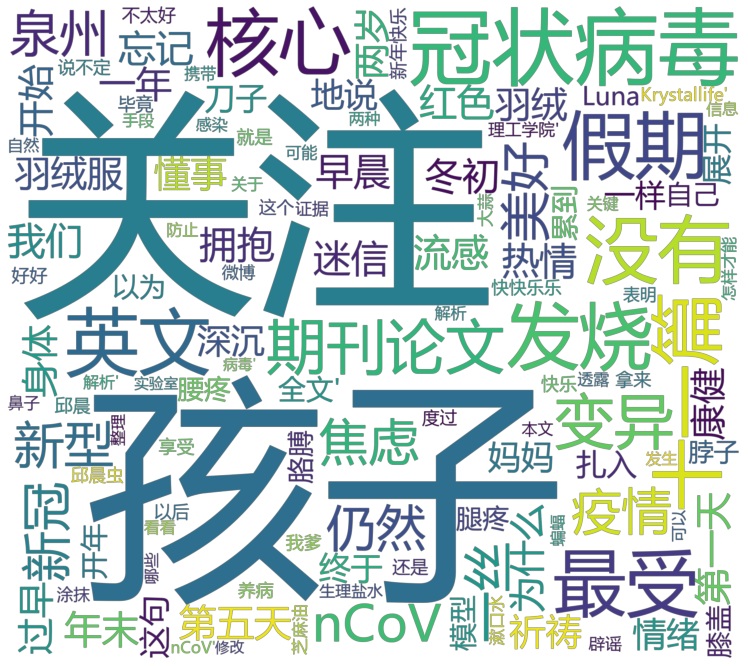

In [23]:
plt.figure(figsize=(14, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### 图片统计
在训练数据（微博）中，有些是有图片的，有些是没有图片的。

我们做一个简单统计：

In [24]:
train_labeled_copy['Pic_Length'] = train_labeled_copy['Pictures'].apply(lambda x: len(eval(x)))
test_copy['Pic_Length'] = test_copy['Pictures'].apply(lambda x: len(eval(x)))

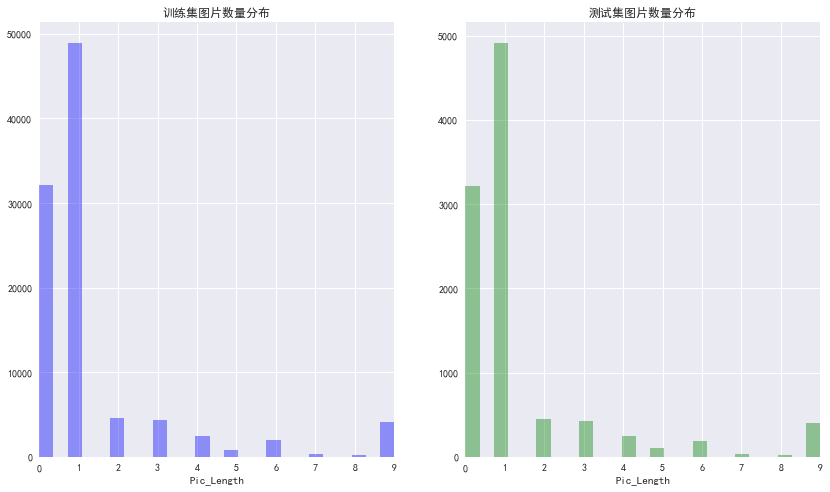

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))
ax1.set_xlim(0, 9)
ax2.set_xlim(0, 9)

sns.distplot(train_labeled_copy['Pic_Length'], bins=25, ax=ax1, color='blue', kde=False)
sns.distplot(test_copy['Pic_Length'], bins=25, ax=ax2, color='green', kde=False)

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

ax1.set_title('训练集图片数量分布')
ax2.set_title('测试集图片数量分布')

plt.show()

可以看出分布非常近似，这里基本没什么问题。

大多数人都是不发图片或者发一张图片。

至于9图比7、8图的多，6图比5图多，大概是强迫症...

### 视频统计

视频计数在训练集和测试集中分布：

In [26]:
train_labeled_copy['With_Video'] = train_labeled_copy['Videos'].apply(lambda x: len(eval(x)))
test_copy['With_Video'] = test_copy['Videos'].apply(lambda x: len(eval(x)))

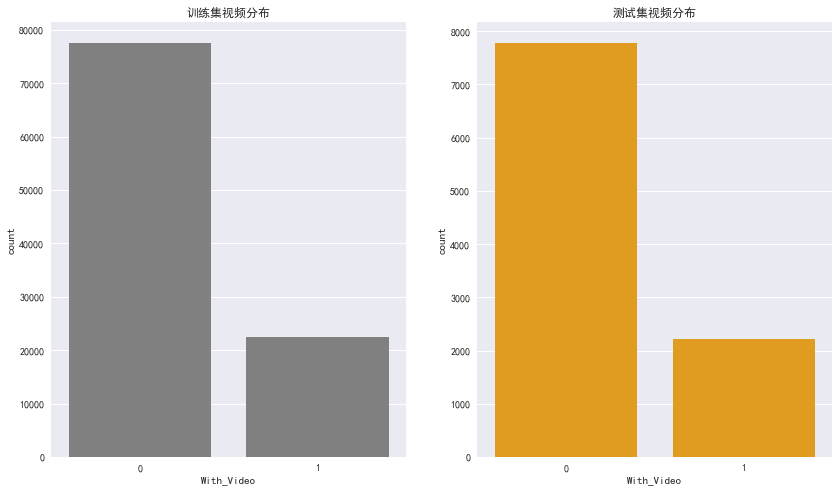

In [27]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 8))

sns.countplot(train_labeled_copy['With_Video'], ax=ax1, color='grey')
sns.countplot(test_copy['With_Video'], ax=ax2, color='orange')

plt.rcParams['font.sans-serif']=['SimHei']
plt.rcParams['axes.unicode_minus'] = False

ax1.set_title('训练集视频分布')
ax2.set_title('测试集视频分布')

plt.show()

看起来分布是一致的。

接下来我们看看带视频和不带视频的情感标签分布。

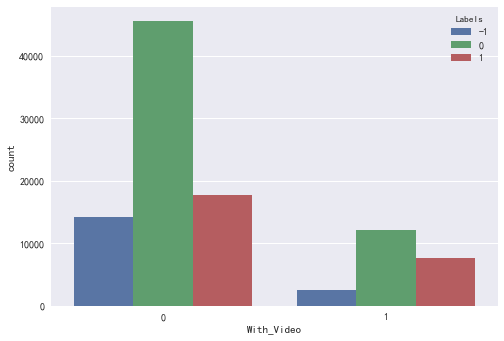

In [28]:
train_labeled_copy_2 = train_labeled_copy[(train_labeled_copy["Labels"] == '0') |
                                          (train_labeled_copy["Labels"] == '1') |
                                          (train_labeled_copy["Labels"] == '-1')]

sns.countplot(x='With_Video', hue='Labels', data= train_labeled_copy_2,
              order = train_labeled_copy['With_Video'].dropna().value_counts().index)
plt.show()

可以看出，大部分带视频的微博，其情感为中性。

但是明显的，相对于不带视频的微博，带视频的微博中 `正面情感` 比例比 `负面情感` 的比例更高。

## 含有负面词语的微博标签

如果有一些词语有强烈的感情色彩，那么他们的整体标签是怎么分布的？

实际上这涉及到了训练集标签到底是如何标注的，因为很多标签很迷，让我自己标都不一定能标对。

考虑做一个负面词云。

In [29]:
p = re.compile(r"伤心|难受|死亡|难过|孤独|疼痛|救救|焦虑|心慌|愤怒|生气|骂人|招谁惹谁|可怕|阴谋论")

train_labeled_copy['With_shangxin'] = train_labeled_copy['Chinese_Content'].apply(lambda x:0 if (p.search(str(x)) is None) else 1)  # 伤心
# test_copy['With_Video'] = test_copy['Videos'].apply(lambda x: len(eval(x)))

In [30]:
train_labeled_copy[train_labeled_copy["With_shangxin"] == 1]["Labels"].value_counts()

0              2244
-1             1952
1               420
empty_label       3
4                 1
9                 1
Name: Labels, dtype: int64

## 分情绪统计

### 负面情绪

In [31]:
neg_words_train = train_labeled_copy[train_labeled_copy['Labels'] == "-1"]

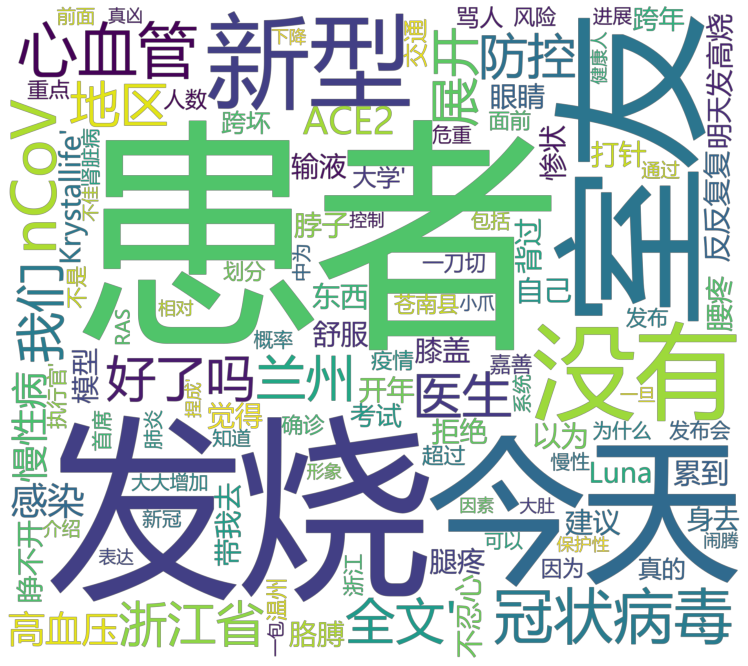

In [32]:
wc = WordCloud(font_path=font, 
               max_words=2000,
               width=1800, 
               height=1600, 
               mode='RGBA', 
               background_color=None).generate(str(neg_words_train['Chinese_Content_cut'].values))

plt.figure(figsize=(14, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### 中性情绪

In [33]:
normal_words_train = train_labeled_copy[train_labeled_copy['Labels'] == "0"]

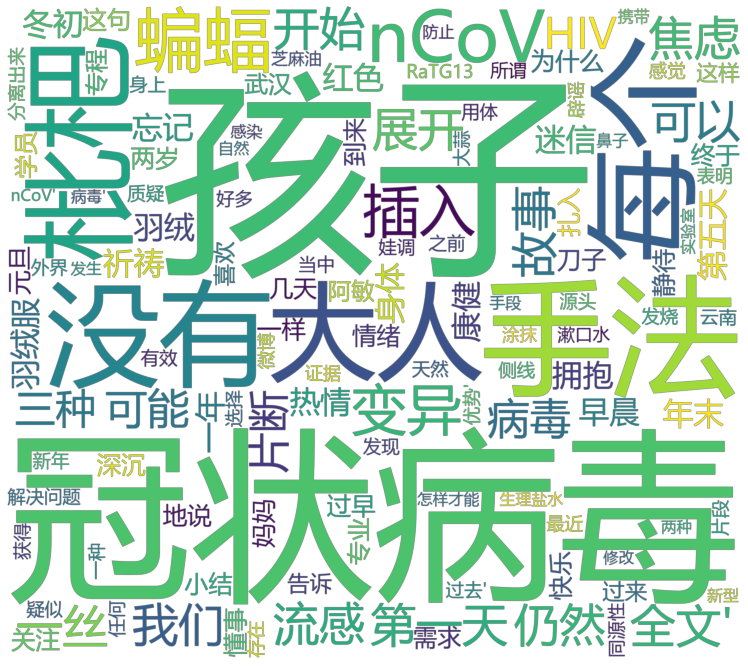

In [34]:
wc = WordCloud(font_path=font, 
               max_words=2000,
               width=1800, 
               height=1600, 
               mode='RGBA', 
               background_color=None).generate(str(normal_words_train['Chinese_Content_cut'].values))

plt.figure(figsize=(14, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### 正面情绪

In [35]:
pos_words_train = train_labeled_copy[train_labeled_copy['Labels'] == "1"]

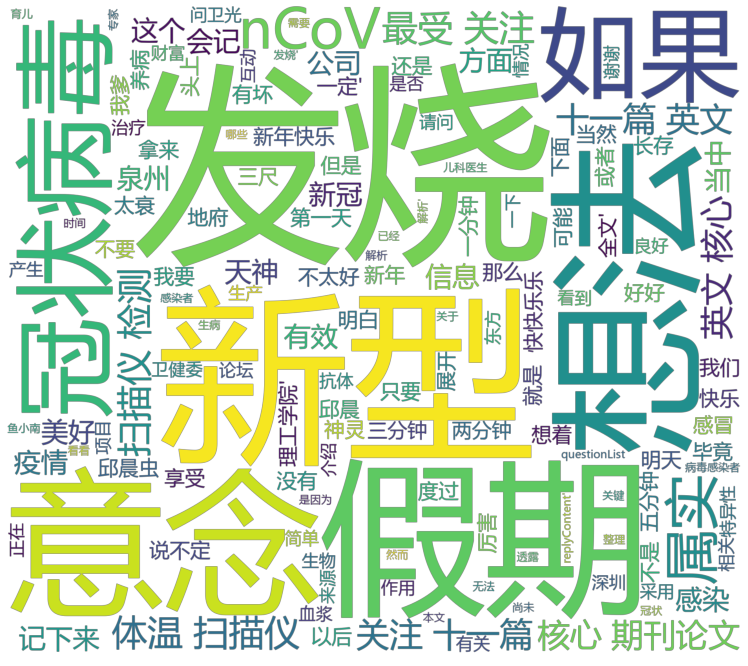

In [36]:
wc = WordCloud(font_path=font, 
               max_words=2000,
               width=1800, 
               height=1600, 
               mode='RGBA', 
               background_color=None).generate(str(pos_words_train['Chinese_Content_cut'].values))

plt.figure(figsize=(14, 12))
plt.imshow(wc, interpolation='bilinear')
plt.axis('off')
plt.show()

### 负面情绪词语频数统计

In [37]:
all_neg_words = []
for cut_res in neg_words_train["Chinese_Content_cut"].values:
    res = cut_res.split(" ")
    for word in res:
        all_neg_words.append(word)

In [38]:
dic_1 = collections.Counter(all_neg_words)

In [39]:
# 对字典按value排序
neg_words_list = sorted(dic_1.items(), key=lambda x: x[1], reverse=True)
print(neg_words_list[0:100])

[('武汉', 3056), ('展开', 2708), ('全文', 2705), ('没有', 2659), ('疫情', 2546), ('口罩', 2218), ('真的', 2149), ('肺炎', 2112), ('自己', 2020), ('一个', 1913), ('确诊', 1897), ('现在', 1891), ('我们', 1781), ('病毒', 1748), ('什么', 1715), ('医院', 1698), ('这个', 1627), ('就是', 1514), ('不是', 1452), ('感染', 1449), ('病例', 1350), ('知道', 1306), ('新型', 1300), ('医生', 1252), ('今天', 1215), ('##', 1193), ('还是', 1155), ('已经', 1094), ('时候', 1066), ('患者', 1063), ('可以', 999), ('他们', 976), ('不能', 953), ('怎么', 924), ('上班', 919), ('这么', 917), ('因为', 914), ('隔离', 901), ('野味', 893), ('开始', 889), ('冠状病毒', 881), ('你们', 873), ('发烧', 847), ('大家', 842), ('看到', 812), ('不要', 798), ('中国', 785), ('还有', 781), ('这样', 763), ('为什么', 749), ('觉得', 736), ('可能', 732), ('微博', 730), ('蝙蝠', 707), ('希望', 693), ('如果', 692), ('这种', 690), ('视频', 677), ('但是', 676), ('工作', 661), ('湖北', 651), ('出来', 646), ('不会', 644), ('新冠', 640), ('那么', 639), ('咳嗽', 635), ('这些', 620), ('每天', 607), ('感觉', 602), ('一下', 600), ('全国', 596), ('一直', 585), ('问题', 569), ('在家', 565), ('那些

### 中性情绪词语频数统计

In [40]:
all_normal_words = []
for cut_res in normal_words_train["Chinese_Content_cut"].values:
    res = cut_res.split(" ")
    for word in res:
        all_normal_words.append(word)

In [41]:
dic_2 = collections.Counter(all_normal_words)

In [42]:
# 对字典按value排序
normal_words_list = sorted(dic_2.items(), key=lambda x: x[1], reverse=True)
print(normal_words_list[0:100])

[('肺炎', 16217), ('疫情', 15731), ('展开', 14670), ('全文', 14633), ('新型', 13451), ('武汉', 11315), ('冠状病毒', 10878), ('感染', 8405), ('病例', 7804), ('确诊', 7736), ('口罩', 7396), ('##', 6971), ('病毒', 6934), ('患者', 6656), ('医院', 6572), ('防控', 6003), ('我们', 5368), ('链接', 4976), ('没有', 4895), ('新冠', 4843), ('微博', 4834), ('网页', 4745), ('可以', 4540), ('视频', 4528), ('一个', 4341), ('工作', 4199), ('中国', 3904), ('自己', 3837), ('这个', 3835), ('隔离', 3715), ('大家', 3307), ('传播', 3239), ('湖北', 3160), ('2020', 3092), ('医生', 3081), ('目前', 3006), ('国家', 3004), ('就是', 2924), ('今天', 2923), ('新增', 2855), ('什么', 2824), ('现在', 2821), ('治疗', 2781), ('全国', 2706), ('出现', 2622), ('新闻', 2612), ('不要', 2568), ('健康', 2558), ('可能', 2479), ('不是', 2470), ('消毒', 2459), ('10', 2441), ('发现', 2418), ('专家', 2408), ('发热', 2406), ('出院', 2356), ('症状', 2339), ('需要', 2307), ('已经', 2304), ('时间', 2231), ('真的', 2206), ('发布', 2197), ('人员', 2194), ('知道', 2187), ('还是', 2185), ('情况', 2184), ('预防', 2146), ('希望', 2062), ('一起', 2040), ('开始', 2034), ('如果', 2

### 正面情绪词语频数统计

In [43]:
all_pos_words = []
for cut_res in pos_words_train["Chinese_Content_cut"].values:
    res = cut_res.split(" ")
    for word in res:
        all_pos_words.append(word)

In [44]:
dic_3 = collections.Counter(all_pos_words)

In [45]:
# 对字典按value排序
pos_words_list = sorted(dic_3.items(), key=lambda x: x[1], reverse=True)
print(pos_words_list[0:100])

[('加油', 10351), ('疫情', 8239), ('武汉', 8226), ('我们', 5811), ('中国', 5422), ('致敬', 4123), ('肺炎', 4007), ('展开', 3981), ('全文', 3972), ('一起', 3797), ('新型', 3449), ('##', 3377), ('希望', 2659), ('防控', 2504), ('行动', 2375), ('医院', 2340), ('一线', 2329), ('医护人员', 2203), ('自己', 2119), ('抗击', 2109), ('平安', 2065), ('大家', 2061), ('湖北', 1983), ('视频', 1935), ('一定', 1770), ('微博', 1741), ('冠状病毒', 1739), ('你们', 1735), ('一个', 1685), ('努力', 1660), ('口罩', 1613), ('患者', 1591), ('感谢', 1550), ('2020', 1542), ('工作', 1456), ('没有', 1437), ('真的', 1403), ('感染', 1395), ('可以', 1344), ('治愈', 1326), ('他们', 1309), ('这个', 1296), ('哈哈哈', 1289), ('医生', 1283), ('今天', 1230), ('肖战', 1227), ('健康', 1223), ('确诊', 1190), ('出院', 1189), ('所有', 1184), ('奋战', 1140), ('打卡', 1139), ('朱一龙', 1129), ('辛苦', 1117), ('公益', 1106), ('全国', 1097), ('病毒', 1096), ('就是', 1090), ('前线', 1077), ('战疫', 999), ('捐赠', 984), ('新冠', 978), ('起来', 957), ('打赢', 957), ('抗疫', 956), ('祈福', 955), ('链接', 954), ('病例', 948), ('人民', 945), ('白衣天使', 918), ('医疗队', 915), ('网页'

### 负面独有词汇统计

In [46]:
neg_only = []
for key in neg_words_list:
    if (key[0] not in dic_2) and (key[0] not in dic_3):
        neg_only.append(key)

In [47]:
neg_only[0:100]

[('出借', 22),
 ('之敌', 19),
 ('必死', 15),
 ('嘴瘾', 15),
 ('划掉', 15),
 ('广告创意', 14),
 ('即小三', 14),
 ('白牡丹', 14),
 ('对小王', 13),
 ('这心', 12),
 ('地痞流氓', 12),
 ('大肆宣传', 10),
 ('女厕所', 10),
 ('社达', 10),
 ('乙流', 9),
 ('讨饭', 9),
 ('痛心疾首', 9),
 ('翁秋秋', 9),
 ('私利', 9),
 ('黑恶势力', 9),
 ('犊子', 8),
 ('MWC', 8),
 ('活量', 8),
 ('死绝', 8),
 ('虫虫', 8),
 ('多行不义', 8),
 ('七世', 8),
 ('傻了眼', 8),
 ('Noki', 8),
 ('露马脚', 8),
 ('祁县', 8),
 ('遗言', 7),
 ('渣医', 7),
 ('连篇', 7),
 ('喷粪', 7),
 ('自毙', 7),
 ('没控', 7),
 ('泛案', 7),
 ('案中', 7),
 ('SARS2', 7),
 ('祭坛', 7),
 ('维以', 7),
 ('不永伤', 7),
 ('六义', 7),
 ('蒲塞', 7),
 ('Stradivari', 7),
 ('脑仁疼', 7),
 ('防弹衣', 7),
 ('nmd', 6),
 ('堵奶', 6),
 ('政令', 6),
 ('我活', 6),
 ('2829', 6),
 ('吃得下', 6),
 ('贱种', 6),
 ('狗日', 6),
 ('死不足惜', 6),
 ('失语', 6),
 ('气死人', 6),
 ('FindJapan', 6),
 ('香屯村', 6),
 ('违占', 6),
 ('问责云昆', 6),
 ('拦路抢劫', 6),
 ('还特', 6),
 ('噪声', 6),
 ('双牌县', 6),
 ('七弟', 6),
 ('DRAWCOOLxi', 6),
 ('税负', 6),
 ('邢立', 6),
 ('OldFanfan', 6),
 ('正常化', 6),
 ('糜烂', 5),
 ('咽不下', 5),
 ('豪华酒店', 5),

In [48]:
len(neg_only)

14164

### 中性独有词汇统计

In [49]:
norm_only = []
for key in normal_words_list:
    if (key[0] not in dic_1) and (key[0] not in dic_3):
        norm_only.append(key)

In [50]:
norm_only[0:100]

[('蓝光', 103),
 ('打底', 93),
 ('妆前', 88),
 ('腰果', 77),
 ('浅谈', 73),
 ('帮寻', 63),
 ('青兰', 51),
 ('全效', 51),
 ('亿人次', 46),
 ('A6Pk09lQ', 42),
 ('nbsp', 41),
 ('HiLink720', 40),
 ('轻薄', 39),
 ('60.8%', 39),
 ('72.7%', 39),
 ('66.6%', 39),
 ('每经', 39),
 ('超季', 39),
 ('十九时', 39),
 ('金九银', 39),
 ('静电', 39),
 ('微粒', 38),
 ('申论', 38),
 ('防水', 37),
 ('继续加强', 35),
 ('19.90', 34),
 ('大盘', 34),
 ('液态', 34),
 ('15g', 33),
 ('无毒', 31),
 ('实付', 31),
 ('165', 30),
 ('周泽发', 30),
 ('气血', 30),
 ('第六十二', 30),
 ('退名', 30),
 ('扬改', 30),
 ('故重', 30),
 ('乘禄', 30),
 ('自昌解', 30),
 ('24.9', 29),
 ('气阀', 29),
 ('干线', 29),
 ('原油', 29),
 ('含氯', 29),
 ('6700', 29),
 ('阳离子', 28),
 ('必抢', 28),
 ('股指', 28),
 ('绿豆', 28),
 ('桔梗', 28),
 ('配比', 28),
 ('温病', 27),
 ('收盘', 27),
 ('泌尿', 27),
 ('口服药物', 26),
 ('寻同', 26),
 ('现发', 26),
 ('气垫', 26),
 ('班线', 25),
 ('金丝', 25),
 ('京沪', 25),
 ('因雾', 25),
 ('寻狗', 25),
 ('做熟', 25),
 ('切除', 24),
 ('杆菌', 24),
 ('护眼', 24),
 ('速看', 24),
 ('危险品', 24),
 ('脊柱', 24),
 ('风机', 24),
 ('花草', 24),
 ('科

In [51]:
len(norm_only)

62897

### 正面独有词汇统计

In [52]:
pos_only = []
for key in pos_words_list:
    if (key[0] not in dic_1) and (key[0] not in dic_2):
        pos_only.append(key)

In [53]:
pos_only[0:100]

[('回甜馨', 112),
 ('抚养权', 112),
 ('mdxd', 43),
 ('源代码', 41),
 ('lyn', 41),
 ('走草路', 34),
 ('SourceCode', 28),
 ('待凛冬', 25),
 ('草青', 25),
 ('棚主', 23),
 ('张乔耳', 20),
 ('之河', 20),
 ('鲜语', 18),
 ('总群', 18),
 ('李一桐', 16),
 ('狠来', 16),
 ('一敏', 15),
 ('360417.88', 15),
 ('mxykaSophie', 14),
 ('歌友', 13),
 ('王琳凯', 13),
 ('精精有', 13),
 ('小沈龙', 13),
 ('欢迎光临', 12),
 ('圆之夜', 12),
 ('情深', 12),
 ('Androktasiai', 12),
 ('沙奎', 11),
 ('稍候', 11),
 ('非赢不可', 11),
 ('静儿', 11),
 ('板刷', 11),
 ('第十五', 11),
 ('黄廷', 11),
 ('种抗', 10),
 ('19000', 10),
 ('Loong', 10),
 ('小窝群', 10),
 ('果农', 10),
 ('Joer', 10),
 ('笑称', 10),
 ('吴安华', 10),
 ('Vampire', 10),
 ('awsl', 10),
 ('五福', 10),
 ('愿逆', 10),
 ('领金', 10),
 ('卡非佐米', 9),
 ('洒汗', 9),
 ('汪东城', 9),
 ('而安', 9),
 ('甜兴', 9),
 ('菠萝派', 9),
 ('precious', 9),
 ('Maybelline', 9),
 ('秃噜', 9),
 ('禾子', 9),
 ('人民解放军', 9),
 ('坚定信念', 9),
 ('准新娘', 9),
 ('pORA', 9),
 ('杨蓉', 9),
 ('一白张', 9),
 ('ruif', 9),
 ('唐莉佳', 9),
 ('最浅', 9),
 ('条幅', 8),
 ('无难', 8),
 ('投站', 8),
 ('中国青少年发展基金会', 8),
 ('

In [54]:
len(pos_only)

17310

In [55]:
gc.collect()

166

## 对于非标注数据集应用独有词汇标注\

### 正面

In [101]:
train_unlabeled = pd.read_csv('./input/train_dataset/nCoV_900k_train_unlabled_utf8.csv', encoding='utf-8')
train_unlabeled.rename(columns = {"微博id": "Weibo_ID",
                                "微博发布时间": "Publish_Time", 
                                "发布人账号": "Account_ID",
                                "微博中文内容": "Chinese_Content",
                                "微博图片": "Pictures",
                                "微博视频": "Videos",
                                "情感倾向": "Labels"},  inplace=True)

train_unlabeled_copy = train_unlabeled.copy()

In [102]:
# 提取三种独有高频词语放入set
pos_set = set()
sep = "|"


for word in pos_only[0:150]:
    pos_set.add(word[0])

# 粉丝
pos_set.add("后援会")
pos_set.add("后援团")
pos_set.add("韩红")

# 宗教
pos_set.add("观音菩萨")
pos_set.add("文殊菩萨")



pos_string = sep.join(pos_set)

In [103]:
# 手动干掉不合适的
not_poses = ["2829", "DRAWCOOLxi", "2103", "O61", "Noki", "OldFanfan", 
             "0202", "89792", "0.16", "19000", "Adam0616", "种抗", "后", "而安", "小燕", "印痕", "花缪子", "李圆霸", "圆之夜", "mdxd", "1025", 
             "BAZZALX", "mxykaSophie", "Joer", "牦牛", "lyn", "Hanasa", "多支", "平潭", "秃噜", "取而代之"]

for not_pos in not_poses:
    pos_set.discard(not_pos)
    
pos_string = sep.join(pos_set)

In [104]:
print(pos_string)

情深|宗主|年刊|咖图|瓷瓷|爱徒|Vampire|王琳凯|360417.88|板刷|李一桐|之升|SourceCode|同气连枝|观音菩萨|狠来|非赢不可|xfxxzgg|菠萝派|疑问句|之恒|花洒|走草路|欧豪|后援会|precious|文殊菩萨|Loong|欢迎光临|长命百岁|最浅|投站|鬼厉|韩红|小兴|草青|娄勤俭|奎星阁|鬼王|捷讯|艳遇|大男主|杨蓉|茅子|禾子|第十五|再遇|Boogie|雨余秋清|少先队员|尤莲|宗副|回甜馨|蒸蒸日上|阖家幸福|亨圈|无难|愿逆|总群|Samuel|准新娘|唯爱|待凛冬|源代码|小芋|一敏|嗜肉菌|领金|人民解放军|吴安华|泼墨|中国青少年发展基金会|Makerforce|七绝|唐莉佳|海军陆战队|小懒菌|望峰|chachalacha|挺立|稍候|歌好|垄上|歌友|Androktasiai|汪东城|如日|条幅|沙奎|pORA|1905|一龙|ruif|棚主|awsl|或伦地|2540|甜兴|精精有|后援团|宇航|张乔耳|雷米迪维|新疆医科大学|坚定信念|迎福|黄廷|洒汗|静儿|五福|要流|之河|感怀|为雷|李葱|笑称|画小眉|终局|鲜语|卡非佐米|静等|小沈龙|苏有朋|最爱猴|一白张|抚养权|领命|果农|Maybelline|小窝群|于省|封面人物


In [105]:
pattern_pos = re.compile(pos_string)


train_unlabeled_copy["Labels_pos"] = train_unlabeled_copy['Chinese_Content'].apply(lambda x:"2" if (pattern_pos.search(str(x)) is None) else "1")  

In [106]:
train_unlabeled_copy_pos = train_unlabeled_copy[train_unlabeled_copy["Labels_pos"] == "1"]

### 负面

In [107]:
# 提取三种独有高频词语放入set
neg_set = set()
sep = "|"

for word in neg_only[0:150]:
    neg_set.add(word[0])
neg_string = sep.join(neg_set)

In [108]:
# 手动干掉不合适的 - 负面
not_negs = ["2829", "DRAWCOOLxi", "2103", "O61", "Noki", "乙流", "3716", "Kombrig", "七世", "明兮大", "没退", "社达",
            "OldFanfan", "别特", "uu", "还特", "我活", "红十", "类学", "至死不渝", "阮念東", "香屯村", "防弹衣", "双牌县", "六义"
            "方没", "37+6", "噪声", "数多", "案中", "37.6", "维以", "不烦", "vicky", "虫虫", "祁县", "其乐", "广告创意", "木叶", "刘月",
           "正常化", "翁秋秋", "糜烂", "方没", "失语", "均告", "划掉", "咽不下", "嘴瘾", "撞者"]
for not_neg in not_negs:
    neg_set.discard(not_neg)

neg_set.add("nmsl")
neg_set.add("NMSL")
neg_set.add("NM$L")
neg_set.add("憨批")
neg_set.add("带孝子")
neg_set.add("学术腐败")
neg_set.add("道德绑架")
neg_set.add("黑子")

neg_string = sep.join(neg_set)

In [109]:
print(neg_string)

失芯|冒功|nmsl|杀良|太多事|狗日|鲜血淋漓|MWC|泛案|连篇|融触|绽出|问责云昆|算事|气死人|堵奶|这心|太无语|很傻|黑恶势力|地痞流氓|私利|SARS2|行径|好端端|杀人犯|违占|七弟|豪华酒店|阿忆|大肆宣传|多行不义|Stradivari|视奸|算编|慌慌张张|活量|六义|命顶|考列|取而代之|卢英潭|带孝子|何性|傻了眼|wcnm|邢立|追刑|必死|女厕所|李鸿印|额上|政令|贱种|NMSL|FindJapan|红字|nmd|廉租房|合法经营|自毙|招远|CNM|操者|学术腐败|即小三|税负|余温|犊子|哭过|涨红了脸|乱子|二号线|喷粪|前也己|cnmcnmcnm|奴役|还花|黑子|惶惶不可终日|憨批|脑仁疼|下三滥|其转|不永伤|mlgb|蒲塞|露马脚|祭坛|渣医|死法|吃得下|家屬|之敌|道德绑架|痛心疾首|死绝|闲话|糟蹋|死妈|白牡丹|污人|讨饭|没控|出借|十八层|高堂|NM$L|遗言|对小王|拦路抢劫|死不足惜


In [110]:
pattern_neg = re.compile(neg_string)


train_unlabeled_copy["Labels_neg"] = train_unlabeled_copy['Chinese_Content'].apply(lambda x:"2" if (pattern_neg.search(str(x)) is None) else "-1")  

In [111]:
train_unlabeled_copy_neg = train_unlabeled_copy[train_unlabeled_copy["Labels_neg"] == "-1"]

### 中性

In [112]:
# 提取三种独有高频词语放入set
norm_set = set()
sep = "|"

for word in norm_only[0:150]:
    norm_set.add(word[0])
norm_string = sep.join(norm_set)

In [113]:
# 手动干掉不合适的
not_norms = ["HiLink720", "69.00", "6700", "A6Pk09lQ", "24.9", "165", "66.6%", 
             "304", "60.8%", "45%", "72.7%", "19.90", "宇航", "倾斜", "韦是"]
for not_norm in not_norms:
    norm_set.discard(not_norm)

# 带货
norm_set.add("元包邮")
norm_set.add("券后")
norm_set.add("折上折")

# 新闻
norm_set.add("新闻发言人")
norm_set.add("领导小组")
norm_set.add("办公室主任")
norm_set.add("紧急通知")
norm_set.add("小知识")
norm_set.add("微博辟谣")
norm_set.add("政府公告")
    
norm_string = sep.join(norm_set)

In [114]:
print(norm_string)

白术|不锈钢|杆菌|股指|麻疹|两款|萃取|肤质|通俗|紧急通知|新闻发言人|大盘|绿豆|棕色|妆前|自昌解|nCoVEC50|班线|省界|花草|VeroE6|中仅|切除|元包邮|卷后|金丝|做熟|温病|含氯|恶性肿瘤|猫鼠|良品|会商|脊髓灰质炎|试题|弹力|周泽发|瘙痒|第六十二|李莫愁|时应|买入|因雾|轻薄|腰果|亲子|政府公告|气虚|科技股|折上折|乳胶|每经|美伊|静电|防水|帮寻|应立即|或活|干线|配比|麦芽|券后|罗志祥|止痒|茯苓|泌尿|寻同|配戴|申论|医养|大大降低|继续加强|超季|口服药物|奠定|体弱|必抢|打底|行车道|环境污染|故重|考试院|十九时|速看|可行性|平衡木|乘禄|办公室主任|原装|桔梗|减速慢行|擦手|气垫|nbsp|全效|棉纱|活性炭|气阀|领导小组|液态|细胞膜|柔韧|防辐射|附着|原油|气血|飞利浦|金九银|国省|脊柱|立交|京沪|制成|微博辟谣|扬改|可操作性|子陵|尖锐湿疣|浅谈|无毒|胎菊|15g|阳离子|耐用|微粒|收盘|护眼|投保|退名|危险品|青兰|实付|亿人次|托福考试|冲水|做达芦|售票|蓝光|益气|寻狗|小知识|同仁堂|风机|男科|现发|丛亮


In [115]:
pattern_norm = re.compile(norm_string)


train_unlabeled_copy["Labels_norm"] = train_unlabeled_copy['Chinese_Content'].apply(lambda x:"2" if (pattern_norm.search(str(x)) is None) else "0")  

In [116]:
train_unlabeled_copy_norm = train_unlabeled_copy[train_unlabeled_copy["Labels_norm"] == "0"]

### 拼接

In [117]:
frames = [train_unlabeled_copy_norm, train_unlabeled_copy_neg, train_unlabeled_copy_pos]

In [118]:
result = pd.concat(frames)

In [119]:
result = result.drop_duplicates(subset=['Chinese_Content'], keep='first')

In [120]:
result.to_csv("extra_labels_utf8.csv", index=False)
result.to_csv("extra_labels_ANSI.csv", encoding='gb18030', index=False)

### 整合

In [121]:
# norm
result_norm = result[(result["Labels_pos"] == "2") & (result["Labels_neg"] == "2")]
result_norm['Labels'] = "0"

In [122]:
# neg
result_neg = result[(result["Labels_pos"] == "2") & (result["Labels_neg"] == "-1")]
result_neg['Labels'] = "-1"

In [123]:
# pos
result_pos = result[(result["Labels_pos"] == "1") & (result["Labels_neg"] != "-1")]
result_pos['Labels'] = "1"

In [124]:
result_norm.shape

(25972, 10)

In [125]:
result_neg.shape

(4587, 10)

In [126]:
result_pos.shape

(15761, 10)

In [127]:
frames_2 = [result_norm, result_neg, result_pos]

In [128]:
labeled_result = pd.concat(frames_2)

In [129]:
labeled_result = labeled_result.drop(['Labels_pos', 'Labels_norm', 'Labels_neg'], axis=1)

In [130]:
labeled_result.to_csv("final_labels_utf8.csv", index=False)
labeled_result.to_csv("final_labels_ANSI.csv", encoding='gb18030', index=False)

In [ ]:
# 最后记得拼接起来就行了

In [97]:
check = "#每日一黑台湾省#还是得提醒各位我们这边忙着抗新型肺炎的时候，台湾又在给自己加戏码1.台湾防疫指挥中心提醒，如自武汉及其邻近区域来台，入境时，如出现发烧、咳嗽、呼吸急促等症状，无论是否服用退烧药、止咳药，请主动向机场或港口检疫人员报到，接受健康评估，如未据实通报将会处以罚锾，最高15?展开全文c"

In [98]:
pattern_neg.search(str(check))

In [99]:
pattern_pos.search(str(check))

In [100]:
pattern_norm.search(str(check))

<re.Match object; span=(73, 75), match='现发'>

## 替换用户名

用户转发的内容通常是

`//@失落宇航员:` 形式，需要写个正则替换。

例句：

"来了！//@一也行一:气死我了气死我了气死我了，洗完澡就带妆？头发秒干？你究竟藏了什么好用的高科技？求速分享！众所周知别人发烧时不要摸额头会八级烫伤(说胡话中//@只是忘记好多:老公老公！！！！//@哔哩吧la哔哩吧la:@只是忘记好多集美快来!是你的郎君!"

In [2]:
test = "来了！//@一也行一:气死我了气死我了气死我了，洗完澡就带妆？头发秒干？你究竟藏了什么好用的高科技？求速分享！众所周知别人发烧时不要摸额头会八级烫伤(说胡话中//@只是忘记好多:老公老公！！！！//@哔哩吧la哔哩吧la:@只是忘记好多集美快来!是你的郎君!"

In [14]:
reCmp1 = re.compile(r"(//@.*?:)", re.S)
# reCmp2 = re.compile(r"(/)(/@.*?)(:)", re.S)
print(reCmp1.findall(test))

['//@一也行一:', '//@只是忘记好多:', '//@哔哩吧la哔哩吧la:']


In [17]:
len(reCmp1.findall(test))

3

In [16]:
re.sub(reCmp1, "//", test)

'来了！//气死我了气死我了气死我了，洗完澡就带妆？头发秒干？你究竟藏了什么好用的高科技？求速分享！众所周知别人发烧时不要摸额头会八级烫伤(说胡话中//老公老公！！！！//@只是忘记好多集美快来!是你的郎君!'

### 结语

后续看空闲再更新吧...希望这份简单的EDA对大家有所帮助。